In [3]:
import random
from numpy.random import sample as rs
from numpy import hstack as hs
from numpy import newaxis as na
from radd import theta, learn, lca
from scipy.stats import ttest_rel as ttrel
from matplotlib import animation
from scipy.stats.distributions import norm, uniform
from scipy.misc import factorial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from JSAnimation import IPython_display, HTMLWriter
from matplotlib import animation
from IPython.display import HTML

In [4]:
dt=.0005
si=.01
tb=.56
ntot=1000
dx=np.sqrt(si*dt)

prior = uniform.rvs(0,1,1000)

In [5]:
temporal_dynamics = lambda p, t: np.cosh(p['xb'][:,na]*t)
resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=2)*dt
ss_resp_up = lambda trace, a: np.argmax((trace.T>=a).T, axis=3)*dt
resp_lo = lambda trace: np.argmax((trace.T<=0).T, axis=3)*dt
RT = lambda ontime, rbool: ontime[:,na]+(rbool*np.where(rbool==0, np.nan, 1))
RTQ = lambda zpd: map((lambda x:mq(x[0][x[0]<x[1]], prob)), zpd)
prop = lambda n, k: factorial(n)/(factorial(k)*factorial(n-k))
likelihood = lambda fact, prior, n, k: (fact*prior**k)*(1-prior)**(n-k)


In [6]:
p = theta.get_default_inits(kind='pro', depends_on={'v':'pGo'})

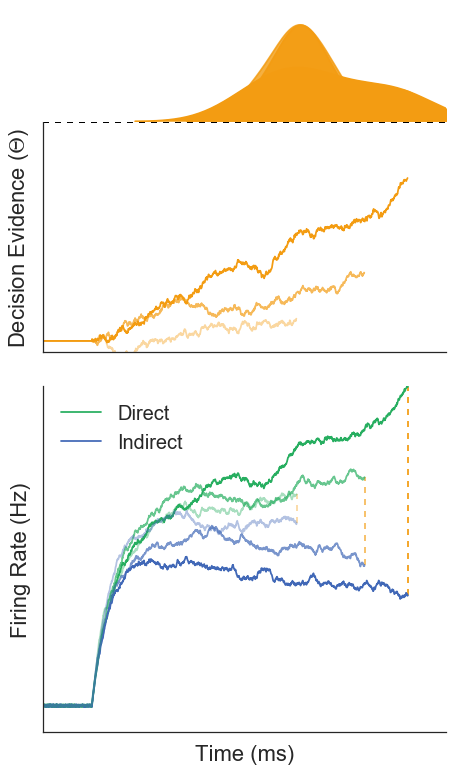

In [8]:
sns.set(style='white', font_scale=2.)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,13))

IoRT=lca.simulate_network_rts()

rd1, ri1, dv1 = lca.decision_network(Id=3., Ii=3., Io=2.5, g=13, b=34, rmax=60, wdi=.29, wid=.2, si=2.)
rd2, ri2, dv2 = lca.decision_network(Id=3., Ii=3., Io=2.5, g=13, b=34, rmax=60, wdi=.24, wid=.2, si=2.)
rd3, ri3, dv3 = lca.decision_network(Id=3., Ii=3., Io=2.5, g=13, b=34, rmax=60, wdi=.2, wid=.2, si=2.)
data=[[rd1, ri1, dv1, 1, True], [rd2, ri2, dv2, .7, False], [rd3, ri3, dv3, .4, False]]
xlim=(0,len(rd1)+150)

for i, dat in enumerate(data):
    dat[0]=dat[0][:len(dat[2])+1]
    dat[1]=dat[1][:len(dat[2])+1]
    lca.dual_space_plot(ax2, ax1, dat[0], dat[1], dat[2], alpha=dat[3], isfirst=dat[4], i=i, xlim=xlim)
lca.plot_rt_distributions(ax2, ax1, np.asarray(IoRT), xlim)

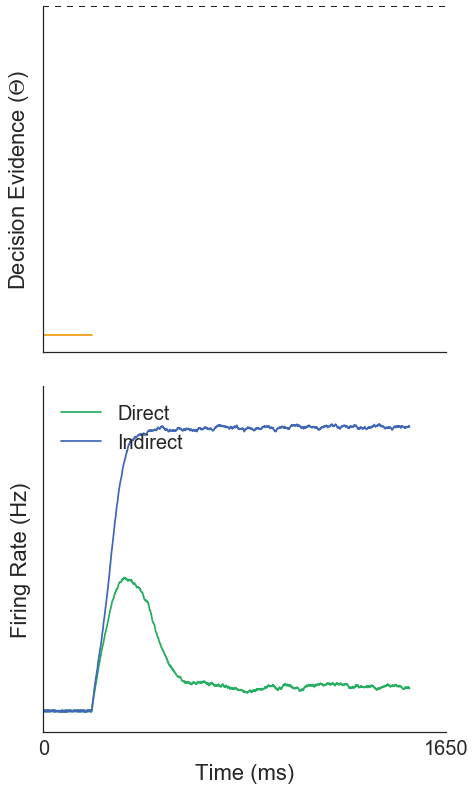

In [13]:
sns.set(style='white', font_scale=2.)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,13))
    
axx=None
rd1, ri1, dv1 = lca.decision_network(Id=4.3, Ii=4.6, Io=4.05, g=11, b=30, rmax=60, wid=.2, wdi=.2, k=1, si=1.53, dt=.001, tau=.02)
#Id=3.5, Ii=3.5, Io=3., wdi=.22, wid=.22, k=.85, si=2.3, dt=.001, tau=.05, tmax=1.5, rmax=70, b=35, g=15, ntrials=10, y=1, Z=20, IoMax=4.5
#rd2, ri2, dv2 = lca.decision_network(Id=3.8, Ii=2.6, Io=3.6, g=13, b=34, rmax=60, wid=.21, wdi=.21)
#rd3, ri3, dv3 = lca.decision_network(Id=3.8, Ii=2.6, Io=2.8, g=13, b=34, rmax=60, wid=.21, wdi=.21)
#data=[[rd1, ri1, dv1, 1, True], [rd2, ri2, dv2, .7, False], [rd3, ri3, dv3, .5, False]]
data=[[rd1, ri1, dv1, 1, True]]
xlim=(0,len(rd1)+150)
for i, dat in enumerate(data):
    lca.dual_space_plot(ax2, ax1, dat[0], dat[1], dat[2], rts=None, alpha=dat[3], isfirst=dat[4], i=i, xlim=xlim)
    #rt.append(lca.simulate_network_rts())
    #lca.plot_rt_distributions(ax2, ax1, rts=rt, xlim=xlim)


In [541]:
f.savefig('Choice_Explore_Exploit_decayIo.png', dpi=700)

In [1]:
def di_lca(Id=3, Ii=3, Ix=3, Io=2, Wd=.19, Wi=.19, Wx=.19, k=.84, si=2.3, dt=.01, tau=.05, tmax=5.5, rmax=100, b=50, g=20, ntrials=10, y=1, Z=10, IoMax=4.5):
    """
    tau:       time constant (cf NMDA receptors)
    k:         recurrent excitatory feedback
    w:         strength of cross-inhibition

    rmax:      max rate of cells
    ithresh:   input needed for 1/2-max firing
    idelta:    determines steepness of sigmoidal f-I curve
    """

    Tex = np.arange(0, tmax, dt)

    ntp=len(Tex)
    Rd = np.zeros((ntrials, ntp))+Io
    Ri = np.zeros((ntrials, ntp))+Io
    Rx = np.zeros((ntrials, ntp))+Io


    for tn in xrange(ntrials):

        # generate independent noise for each pop.
        Ed = si*np.sqrt(dt/tau)*rs(ntp) 
        Ei = si*np.sqrt(dt/tau)*rs(ntp)
        Ex = si*np.sqrt(dt/tau)*rs(ntp)

        for i in np.arange(2,ntp):
            Rd[tn,i]=Rd[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Id+k*Rd[tn,i-1]+Wi*Ri[tn,i-1]+Wx*Rx[tn,i-1]-b)/g))-Rd[tn,i-1])+Ed[i]

            Rx[tn,i]=Rx[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Ix+k*Rx[tn,i-1]+Wi*Ri[tn,i-1]+Wd*Rd[tn,i-1]-b)/g))-Rx[tn,i-1])+Ex[i]

            Ri[tn,i]=Ri[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Io + Ii+k*Ri[tn,i-1]+Wd*Rd[tn,i-1]+Wx*Rx[tn,i-1]-b)/g))-Ri[tn,i-1])+Ei[i]
            #Rd[tn,i]=Rd[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Id+k*Rd[tn,i-1]+Wi*Ri[tn,i-1]-ithresh)/idelta))-Rd[tn,i-1])+Ed[i]

            #Ri[tn,i]=Ri[tn,i-1]+dt/tau*(rmax/(1+np.exp(-(Ii+k*Ri[tn,i-1]+Wd*Rd[tn,i-1]-ithresh)/idelta))-Ri[tn,i-1])+Ei[i]

    return Rd, Ri, Rx

ValueError: too many values to unpack

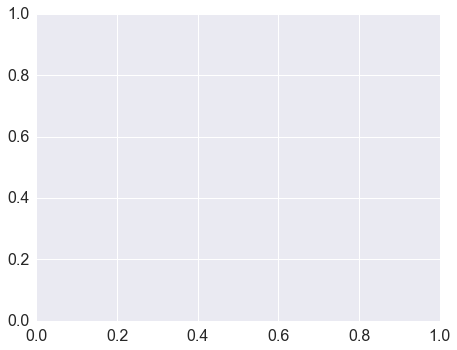

In [2]:
nsims=400
sns.set(font_scale=1.6)
f, ax = plt.subplots(1)
ai=np.linspace(1, 0, nsims)
ad=ai[::-1]
c=sns.blend_palette([colors[-5],colors[10]], n_colors=nsims)
for i, current in enumerate(np.linspace(0,32,nsims)):
    r1, r2,  = di_lca(Id=current, Ii=16, ntrials=1, si=.000001)
    ax.plot(r1[0,:], r2[0,:], color=c[i], alpha=alpha)

ax.plot([0,100], [0,100], color='k')
ax.set_ylabel('$r_{I}\/(Hz)$')
ax.set_xlabel('$r_{D}\/(Hz)$ ')
ax.set_title('Noiseless Competing Attractor Network')
plt.tight_layout()
sns.despine()
#f.savefig('di_nn_noiseless.png', dpi=500)

In [ ]:
sns.set(font_scale=1.5)
f, ax = plt.subplots(1)
a=np.arange(10)*.1
c=sns.blend_palette([colors[10],colors[3]], n_colors=nsims)
for i in range(24):          
        r1, r2 = di_lca(p, Id=i, Ii=10, ntrials=1, si=10)
        if r1[0,-1]>=r2[0,-1]:
            c=colors[10]
        else:
            c=colors[-5]
        ax.plot(r1[0,:], r2[0,:], color=c)
        #ax.plot(r2[0,:], color=colors[3])
#ax.set_xlim(0,300)
ax.set_ylabel('$r_{I}$')
ax.set_xlabel('$r_{D}$')
ax.set_title('Noisy Competing Attractor Network')
plt.tight_layout()
sns.despine()
f.savefig('di_nn_noisy_attractor.png', dpi=500)

In [38]:
sns.set(font_scale=1.5)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5), sharey=False)
r1, r2 = di_lca(p, Id=5., Ii=3., ntrials=10, idelta=22, Wi=-.20, Wd=-.20, tau=.05, k=.9, ithresh=45, rmax=90, si=5)

r3, r4 = di_lca(p, Id=5., Ii=4., ntrials=10, idelta=22, Wi=-.20, Wd=-.20, tau=.05, k=.9, ithresh=45, rmax=90, si=5)

for i, (xd, xi) in enumerate(zip(r1, r2)):
    if i==0:
        a=1
    else:
        a=.03

    ax1.set_title('STR', fontsize=19)
    ax1.plot(xd, color=colors[7], alpha=a, label='dMSN')
    ax1.plot(xi, color=colors[4], alpha=a, label='iMSN')

    ax1.plot(r3[i, :], color=colors[-5], alpha=a, label='dMSN')
    ax1.plot(r4[i, :], color=colors[-9], alpha=a, label='iMSN')

    ax1.set_ylim(0,100)
    ax1.set_ylabel('$sp/s^-1$')


    ax2.set_title('GPi', fontsize=19)
    delta_di = (xd-xi)/np.sqrt(3)
    rt = np.argmax(delta_di>=35)

    delta_di34 = (r3[i, :]-r4[i, :])/5
    rt34 = np.argmax(delta_di34>=35)

    ax2.plot(delta_di[:rt], color='b', alpha=a)
    ax2.plot(delta_di34[:rt34], color='r', alpha=a)

    ax2.hlines(35,0,600,linestyle='--')
    ax2.vlines(rt,0,45,linestyle='-', color='b', lw=.4, alpha=a)
    ax2.vlines(rt34,0,45,linestyle='-', color='r', lw=.4, alpha=a)
    ax1.set_xlabel('Time (ms)')
    ax2.set_xlabel('Time (ms)')

    ax2.set_ylim(0,45)
    plt.tight_layout()
    sns.despine()

#f.savefig('DI_LCA_STR-GPi_Reward.png', dpi=500)

NameError: name 'di_lca' is not defined

In [379]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

sns.set(font_scale=1.5)
#f, ax = plt.subplots(1)
#fig = plt.figure()
#ax = fig.gca(projection='3d')
a=np.arange(50)*.1
c=sns.blend_palette([colors[-3], colors[-5], colors[10]], n_colors=50, input='rgb')

for i in range(50):

    r1, r2, r3 = di_lca(ntrials=10, si=12)
    #color=c[array([r1[0,-1], r2[0,-1], r3[0,-1]]).argmin()]
    #r1, r2 = di_lca(p, Iapp1=15.5, Iapp2=15.5, ntrials=10, si=.001)
    ax.scatter(r2[0,:], r1[0,:], r3[0,:], color=c[i])

ax.set_ylabel('$r_{I}$')
ax.set_xlabel('$r_{D}$')
ax.set_title('Recurrent Competing Attractor Network')
plt.tight_layout()
#sns.despine()
#f.savefig('di_nn_attractor.png', dpi=500)

In [26]:
stim = [['a','b'], ['c', 'd'], ['e','f']]
pc_map = {'vd':['v_0', 'v_1'], 'vi': ['v_0', 'v_1']}
ntrials=150
p['vd']=[.9, .9]; p['vi']=[.4, .4]
p['a'] = .55
try:
p.pop('v')
except Exception:
pass

plist = [deepcopy(p) for i in xrange(len(stim))]
plist = [vectorize_params(p, pc_map, 2) for p in plist]

rand_stim = sum([sorted([0,1,2], key=lambda k: random.random()) for i in xrange(ntrials)], [])

preward = [.8,.7,.6]
nsuccess = 0
alpha_pos = .1
alpha_neg = .1
alpha=.04
traces = []


x = np.sort(uniform.rvs(0,1,1000))
prior = uniform.pdf(x)

stim_ids='abcdef'
ru = {sid: deepcopy(prior) for sid in stim_ids}     
stim_history = {sid: [0, 0] for sid in stim_ids}     
qdict = {sid: [.01] for sid in stim_ids}
di_qvals= {sid: {'vd':[.9], 'vi':[.4]} for sid in stim_ids}
exdict = {sid: [] for sid in stim_ids}

    #di_qvals = {'a':{'vd':[.9], 'vi':[.4]}, 'b':{'vd':[.9], 'vi':[.4]}, 'c':{'vd':[.9], 'vi':[.4]}, 'd':{'vd':[.9], 'vi':[.4]}, 'e':{'vd':[.9], 'vi':[.4]}, 'f':{'vd':[.9], 'vi':[.4]}}
    #ru={'a':x, 'b':[0.01], 'c':[0.01], 'd':[0.01], 'e':[0.01], 'f':[0.01]}

for trial_n, i in enumerate(rand_stim):

    #if trial_n==int(.5*ntrials):
    #      preward=[.2,.3,.4]

    stim_pair_t = stim[i]
    stim_pair_qval = np.asarray([qdict[spt][-1] for spt in stim_pair_t])

    di_theta = plist[i]
    choice, execution_process = di_decision(di_theta)

    xchoice = abs(1-choice)
    traces.append(execution_process)

    if choice==0:
        r = rew_func(preward[i])
    else:
        r = rew_func(1-preward[i])

    # ID of chosen stimulus
    choice_id = stim_pair_t[choice]
    xchoice_id = stim_pair_t[xchoice]
    # update count (no. of times action has been chosen)
    stim_history[choice_id][0]+=1        

    #store decision traces
    exdict[choice_id].append(execution_process[choice])
    exdict[xchoice_id].append(execution_process[xchoice])

    # update chosen action value
    update_q = stim_pair_qval[choice] + alpha*(r-stim_pair_qval[choice])
    qdict[choice_id].append(update_q)
    qdict[xchoice_id].append(stim_pair_qval[xchoice])

    if r:
        # update nsuccess for chosen action
        stim_history[choice_id][1]+=1
        di_theta['vd'][choice] = di_theta['vd'][choice]+di_theta['vd'][choice]*update_q
        di_theta['vi'][choice] = di_theta['vi'][choice]-di_theta['vi'][choice]*(update_q*.5)
        if di_theta['vd'][choice]<0:
              di_theta['vd'][choice]=.01
        if di_theta['vd'][choice]>=5.0:
              di_theta['vd'][choice]=5.0

    else:
        di_theta['vd'][choice] = di_theta['vd'][choice]-di_theta['vd'][choice]*(update_q*.5)
        di_theta['vi'][choice] = di_theta['vi'][choice]+di_theta['vi'][choice]*update_q

        if di_theta['vi'][choice]<0:
              di_theta['vi'][choice]=.01
        if di_theta['vi'][choice]>=5.0:
              di_theta['vi'][choice]=5.0

    di_qvals[stim_pair_t[choice]]['vd'].append(di_theta['vd'][choice])
    di_qvals[stim_pair_t[choice]]['vi'].append(di_theta['vi'][choice])

    # extract action total count (n), nsuccess (s)
    n, s = stim_history[choice_id]
    #xn, xs = stim_history[xchoice_id]
    # estimate posterior uncertainty in action value (from prior)
    ru[choice_id] = (likelihood(prop(n, s), x, n, s)*ru[choice_id])#/((likelihood(prop(n+1, s), x, n, s)*ru[choice_id])+(likelihood(prop(xn+1, xs), x, xn, xs)*ru[xchoice_id]))
    exdict = {sid: np.asarray(exdict[sid]) for sid in exdict.keys()}

In [181]:
x = np.sort(uniform.rvs(0,1,1000))

[{'a': array([ 0.55,  0.55]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 2.98031,  0.70554]),
  'vi': array([  1.01544e-19,   9.11428e-01]),
  'xb': array([ 1.51129,  1.51129])},
 {'a': array([ 0.55,  0.55]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 3.29177,  1.25647]),
  'vi': array([  1.71351e-11,   7.78902e-01]),
  'xb': array([ 1.51129,  1.51129])},
 {'a': array([ 0.55,  0.55]),
  'tr': array([ 0.29213,  0.29213]),
  'vd': array([ 3.5189 ,  3.05501]),
  'vi': array([ 0.03352,  1.83848]),
  'xb': array([ 1.51129,  1.51129])}]

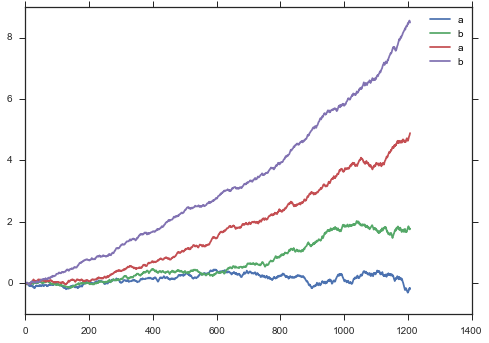

In [29]:
plt.plot(exdict['e'][0], label='a')
plt.plot(exdict['f'][0], label='b')

plt.plot(exdict['e'][-1], label='a')
plt.plot(exdict['f'][-1], label='b')
#plt.plot(qdict['c'], label='c')
#plt.plot(qdict['d'], label='d')

#plt.plot(qdict['e'], label='e')
#plt.plot(qdict['f'], label='f')
plt.legend()

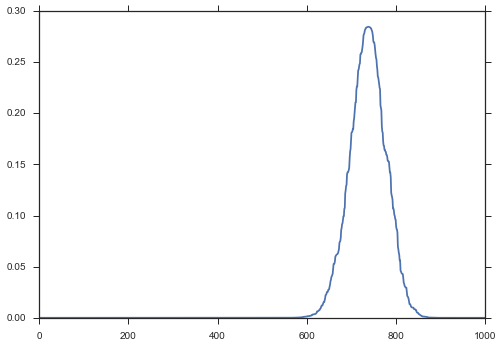

In [15]:
plt.plot(likelihood(prop(n+1, s), x, n, s))#*ru[choice_id])

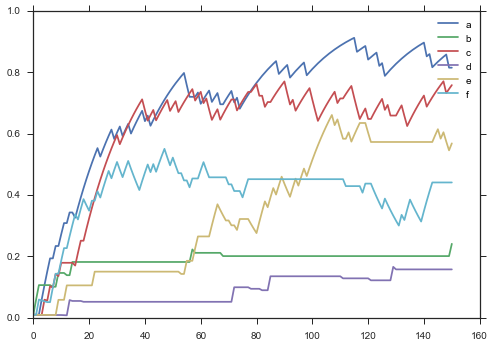

In [16]:
plt.plot(qdict['a'], label='a')
plt.plot(qdict['b'], label='b')

plt.plot(qdict['c'], label='c')
plt.plot(qdict['d'], label='d')

plt.plot(qdict['e'], label='e')
plt.plot(qdict['f'], label='f')
plt.legend()

In [184]:
sns.set(font_scale=1.4, style='white')
f, ax = plt.subplots(1)
flatui=[colors[4], colors[3], colors[-7]]
c=[flatui[0], flatui[0], flatui[1], flatui[1], flatui[2], flatui[2]]
ls=['-', '--']*3
for i, s in enumerate('abcdef'):
      y = (ru[s]-np.mean(ru[s]))/ru[s].std()
      ax.plot(x, y, label=s, linestyle=ls[i], color=c[i])
ax.legend()
ax.set_ylabel('$P(\Theta)$')
ax.set_xlabel('$Q(a_j)$')

sns.despine()
plt.tight_layout()

#plt.savefig('posterior_distributions_actionvalue_surprise.png')

In [35]:
plt.plot(x, likelihood(prop(50, 45.), x, 50, 45)*prior)
plt.plot(x, likelihood(prop(100, 90.), x, 100, 90)*prior)

In [44]:
def rew_func(rprob): 
    if rs()<rprob:
        return 1
    else:
        return 0


def di_decision(p):

    #p = vectorize_params(p, pc_map=pc_map, ncond=nc)

    Pd = 0.5*(1 + p['vd']*dx/si)
    Pi = 0.5*(1 + p['vi']*dx/si)

    Tex = np.ceil((tb-p['tr'])/dt).astype(int)
    #state = np.where(rs(ntot)>.5, 'l', 'r')
    #state=np.sort(state)

    Pd, Pi, Tex = update_execution(p)
    xtb = temporal_dynamics(p, np.cumsum([dt]*Tex.max()))

    direct = xtb*np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
    indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
    execution = np.cumsum(direct-indirect, axis=1)

    choice=np.nan
    while np.isnan(choice):
        choice, p = analyze_execution(execution, p)

    return int(choice), execution


def analyze_execution(execution, p):

    rt = p['tr'] + np.argmax((execution.T>=p['a']).T, axis=1)*dt
    rt[rt==p['tr'][0]]=0

    #rt[rt>0] = p['tr'][0]+rt[rt>0]
    #rt[rt==0] = 999
    #rt = p['tr']+(rx*np.where(rx==0, 999, 1))


    if np.all(rt==0):
        #p['a']=p['a']*.99
        return np.nan, p

    return rt.argmin(), p

In [45]:
%matplotlib inline


In [46]:

plt.plot(qdict['a'], label='a')
plt.plot(qdict['b'], label='b')

plt.plot(qdict['c'], label='c')
plt.plot(qdict['d'], label='d')

plt.plot(qdict['e'], label='e')
plt.plot(qdict['f'], label='f')
plt.legend()

NameError: name 'qdict' is not defined

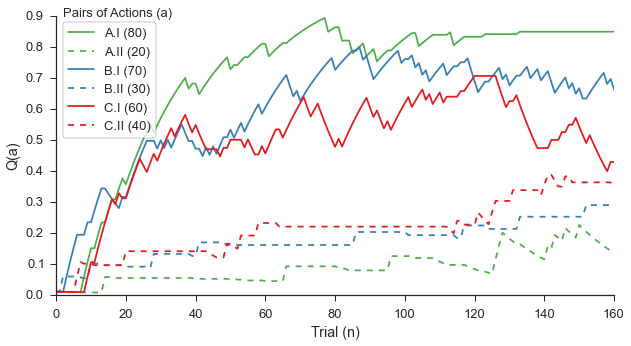

In [99]:
sns.set(font_scale=1.3, style='ticks')
f, ax = plt.subplots(1, figsize=(10,5))
plt.plot(qdict['a'], label='A.I (80)', color=flatui[2])
plt.plot(qdict['b'], label='A.II (20)', color=flatui[2], ls='--')

plt.plot(qdict['c'], label='B.I (70)', color=flatui[1])
plt.plot(qdict['d'], label='B.II (30)', color=flatui[1], ls='--')

plt.plot(qdict['e'], label='C.I (60)', color=flatui[0])
plt.plot(qdict['f'], label='C.II (40)', color=flatui[0], ls='--')
plt.legend(loc=2, fancybox=True, frameon=True, framealpha=.8)
plt.gca().text(2, .9, 'Pairs of Actions (a)', fontsize=13)
plt.gca().set_ylabel('Q(a)')
plt.gca().set_xlabel('Trial (n)')
sns.despine()
plt.savefig('probabilistic_qlearning_diexplorer.png', dpi=600)

In [261]:
qdict['f']

[0, 0.01, -9.9999999999999395e-05]

In [97]:
p = vectorize_params(p, pc_map=pc_map, ncond=nc)
Acc, RT, Resp, Vd, Vi, Ex = [], [], [], [], [], []
#state = np.where(rs(ntot)>.5, 'l', 'r')
#state=np.sort(state)
state=np.hstack([np.sort(['l', 'r']*20)]*3)
for i in xrange(len(state)):

    Pd, Pi, Tex = update_execution(p)
    direct = np.where((rs((nc, Tex.max())).T < Pd),dx,-dx).T
    indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
    execution = np.cumsum(direct-indirect, axis=1)

    resp, rts, acc, p = analyze_execution(execution, p, trial_state=state[i])
    Acc.append(acc); Resp.append(resp); RT.append(rts)
    Vd.append(deepcopy(p['vd'])); Vi.append(deepcopy(p['vi']))                            
Acc=np.asarray(Acc)
RT=np.asarray(RT)
Resp=np.asarray(Resp)
Vd=np.asarray(Vd)    
Vi=np.asarray(Vi)    

In [47]:
def simulate_learning(p, pc_map={'vd':['vd_e', 'vd_u', 'vd_l'], 'vi':['vi_e', 'vi_u', 'vi_l']}, nc=3, lr=array([.4,.3]), nssd=5, dt=.0005, si=.01, ntot=1000, tb=.68):

    dx=np.sqrt(si*dt)
    p = vectorize_params(p, pc_map=pc_map, ncond=nc)

    #Pd, Pi, Tex = update_execution(p)
    #t = np.cumsum([dt]*Tex.max())
    #xtb = temporal_dynamics(p, t)

    #Ph, Th = update_brake(p)
    #ss_index = [np.where(Th<Tex[c],Tex[c]-Th,0) for c in range(nc)]
    #return Pd, Pi
    rts, vd, vi, ex = [], [], [], []
    for i in xrange(ntot):

        Pex, Tex = update_execution(p)
        execution = np.cumsum(np.where((rs((nc, Tex.max())).T < Pex),dx,-dx).T)
        #indirect = np.where((rs((nc, Tex.max())).T < Pi),dx,-dx).T
        #execution = np.cumsum(direct+indirect, axis=1)

        r = np.argmax((execution.T>=p['a']).T, axis=1)*dt
        rt = p['tr']+(r*np.where(r==0, np.nan, 1))
        resp = np.where(rt<tb, 1, 0)

        # find conditions where response was recorded
        #for ci in np.where(~np.isnan(rt))[0]:
        p['vd']=p['vd'] + p['vd']*lr[0]
        p['vi']=p['vi'] - p['vi']*lr[1]


        vd.append(deepcopy(p['vd']))
        vi.append(deepcopy(p['vi']))
        rts.append(rt)
        ex.append(execution)

    vd = np.asarray(vd)
    vi = np.asarray(vi)
    rts = np.asarray(rts)
    ex = np.asarray(ex)
    return vd, vi, rts, ex